# Mount drive (colab)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/MyDrive/visiope
!rm -rf vp_project
!git clone https://github.com/fabioscap/vp_project
%cd vp_project

# Load The Dataset

In [1]:
import utils
import torch
from torch.utils.data import DataLoader,random_split
import torchvision
import model

import matplotlib.pyplot as plt

torch.manual_seed(2806)

p = (0.01,0.1) # remove 90% to 99% of depth values
depth_sampling = lambda x: utils.sample_depth_random(x,p)

depth_transform = torchvision.transforms.Lambda(depth_sampling)
data = utils.NYUDepthV2("../NYUDepthv2", 
                        shape=(240,320),
                        depth_transform=depth_transform,
                        )

train_size = int(0.8*len(data))
test_size = len(data)-train_size

train_data, test_data = random_split(data,[train_size,test_size])

train_loader = DataLoader(train_data,
                    batch_size=4,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=True)

test_loader = DataLoader(test_data,
                    batch_size=1,
                    shuffle=True,
                    num_workers=4,
                    )


# Display one sample

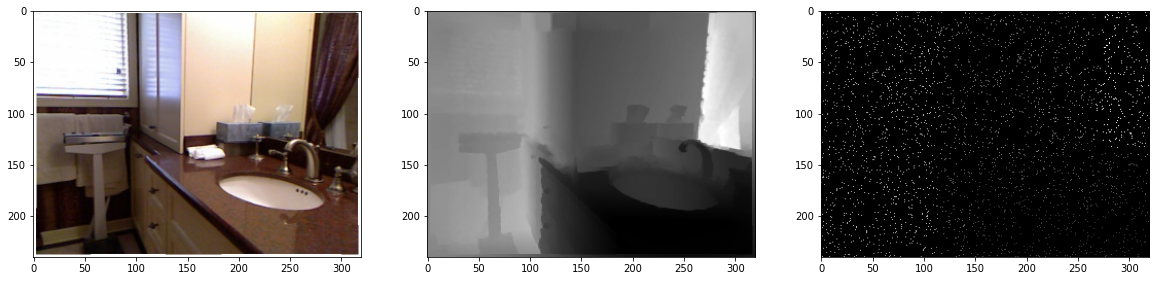

In [2]:
sample = data[int(torch.rand(1).item()*len(data))]

rgb = sample["rgb"]
depth = sample["depth"]
depth_t = sample["depth_t"]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))


ax1.imshow(rgb.permute(1,2,0))
ax2.imshow(depth.squeeze(0),cmap="gray")
ax3.imshow(depth_t.squeeze(0),cmap="gray")

# Load The Model

In [2]:
from torch import optim

import model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# device = torch.device("cpu")

net = model.Net3(shape=(16,32,64,128)).to(device)

optimizer = optim.Adam(net.parameters(),lr=10**-3)

# scheduler = ...

In [3]:
sum(p.numel() for p in net.parameters())

504763

In [ ]:
bl = torch.tensor([1.,2,1])
dif = torch.tensor([1.,0,-1])
Sx = torch.einsum("i,j->ij",bl,dif).reshape((1,1,3,3)).to(device) # outer product
Sy = torch.einsum("i,j->ji",bl,dif).reshape((1,1,3,3)).to(device)

loss = lambda predicted,true: utils.rmse(predicted,true) + 0.1*utils.edge_loss(predicted,true,Sx,Sy)

utils.train(model=net,
            n_epochs = 30,
            loss_fn = loss,
            optimizer= optimizer,
            device = device,
            loader = train_loader,
            log=True)

# Show a prediction

In [4]:
sample = next(iter(test_loader))
rgb = sample["rgb"].to(device)
depth = sample["depth"].to(device)
depth_t = sample["depth_t"].to(device)

with torch.no_grad():
    net.eval()
    out = net(rgb,depth_t).squeeze(0)



torch.Size([1, 16, 240, 320])


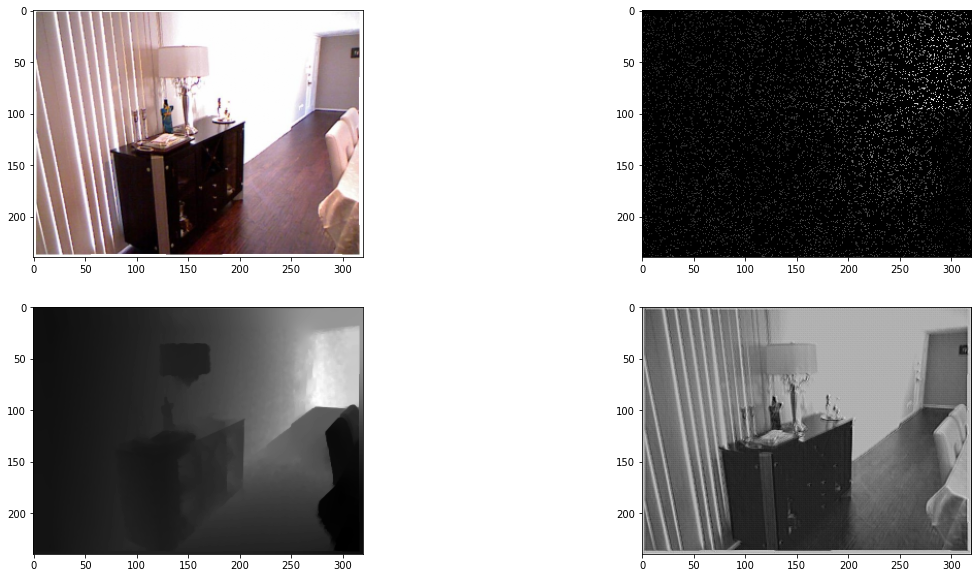

In [5]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))

ax1.imshow(rgb[0,...].permute(1,2,0).cpu())
ax2.imshow(depth_t[0,...].squeeze().cpu(),cmap="gray")
ax3.imshow(depth[0,...].squeeze().cpu(),cmap="gray")
ax4.imshow(out.detach()[0,...].squeeze().cpu(),cmap="gray")

# Accuracy

In [3]:
net.load_state_dict(torch.load('weights/big_net_100.pth'))

<All keys matched successfully>

In [4]:
utils.compute_accuracy(net,utils.d_accuracy,test_loader,device)

tensor(0.9972)